<center><img src="https://i.imgur.com/zRrFdsf.png" width="700"></center>

<a target="_blank" href="https://colab.research.google.com/github/CienciaDeDatosEspacial/TheThematics/blob/main/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# The Thematic map

Last session we created a file with several layers:

In [106]:
import geopandas as gpd

linkGit='https://github.com/Lulo-Vilcarano-MF/Evaluaci-n-Individual-1IAS21-05A1/raw/refs/heads/main/'
linkWorldMaps='worldMaps.gpkg'

we can easily find out the layers in that geopackage file (**worldMaps.gpkg**):

In [107]:
gpd.list_layers(linkGit+linkWorldMaps)

,name,geometry_type
0,rivers,MultiLineString
1,cities,Point
2,countries,MultiPolygon


For the thematics we will retrieve only one layer (map):

In [109]:
countries=gpd.read_file(linkGit+linkWorldMaps,layer='countries')

# see some
countries

,COUNTRY,geometry
0,Aruba (Netherlands),"MULTIPOLYGON (((-69.88223 12.41111, -69.94695 ..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"MULTIPOLYGON (((61.27656 35.60725, 61.29638 35..."
3,Algeria,"MULTIPOLYGON (((-5.15213 30.18047, -5.13917 30..."
4,Azerbaijan,"MULTIPOLYGON (((46.54037 38.87559, 46.49554 38..."
...,...,...
247,South Sudan,"MULTIPOLYGON (((34.21807 9.96458, 34.20722 9.9..."
248,Indonesia,"MULTIPOLYGON (((123.21846 -10.80917, 123.19832..."
249,East Timor,"MULTIPOLYGON (((124.41824 -9.3001, 124.40446 -..."
250,Curacao (Netherlands),"MULTIPOLYGON (((-68.96556 12.19889, -68.91196 ..."


As you see, the GDF above has just two colums; enough to plot a map, but no more than that.

Let me open a DF:

In [110]:
import pandas as pd

DataLink='https://github.com/Lulo-Vilcarano-MF/Evaluaci-n-Individual-1IAS21-05A1/raw/refs/heads/main/FAOSTAT_data_en_9-12-2025.csv'

someData=pd.read_csv(DataLink, encoding='cp1252')
#someData = pd.read_csv(someDataLink, encoding='cp1252')

## data available
someData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       204 non-null    object 
 1   Domain            204 non-null    object 
 2   Area Code (M49)   204 non-null    int64  
 3   Country           204 non-null    object 
 4   Element Code      204 non-null    int64  
 5   Element           204 non-null    object 
 6   Item Code         204 non-null    int64  
 7   Item              204 non-null    object 
 8   Year Code         204 non-null    int64  
 9   Year              204 non-null    int64  
 10  Unit              204 non-null    object 
 11  Value             204 non-null    int64  
 12  Flag              204 non-null    object 
 13  Flag Description  204 non-null    object 
 14  sq_kmGJ           204 non-null    int64  
 15  sq_kmTJ           202 non-null    float64
 16  Region            204 non-null    object 
dt

## Pre Processing: Merging

The DF has some interesting numerical data (_float64_):
* fragility: fragility index 2023 -[details here](https://fragilestatesindex.org/2023/06/14/fragile-states-index-2023-annual-report/)
* co2: metric tonnes of CO2 emmitted -[details here](https://www.cia.gov/the-world-factbook/field/carbon-dioxide-emissions/country-comparison/)
* sq_km: country area -[details here](https://www.cia.gov/the-world-factbook/field/area/country-comparison/)
* num_airports: count of airports in the country -[details here](https://www.cia.gov/the-world-factbook/field/airports/country-comparison/)
* population: country population  -[details here](https://www.cia.gov/the-world-factbook/field/population/country-comparison/)
* mobiles: total number of mobile cellular telephone subscribers -[details here](https://www.cia.gov/the-world-factbook/field/telephones-mobile-cellular/country-comparison/)

There are also other columns that may be of help:

In [111]:
someData.head()

,Domain Code,Domain,Area Code (M49),Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,sq_kmGJ,sq_kmTJ,Region
0,BE,Bioenergy,4,Afghanistan,5852,Energy production,6525,Fuelwood,2022,2022,TJ,18558,X,Figure from external organization,652230000,652230.0,Asia
1,BE,Bioenergy,8,Albania,5852,Energy production,6525,Fuelwood,2022,2022,TJ,6155,X,Figure from external organization,28748000,28748.0,Europe
2,BE,Bioenergy,12,Algeria,5852,Energy production,6525,Fuelwood,2022,2022,TJ,741,X,Figure from external organization,2381740000,2381740.0,Africa
3,BE,Bioenergy,24,Angola,5852,Energy production,6525,Fuelwood,2022,2022,TJ,177651,X,Figure from external organization,1246700000,1246700.0,Africa
4,BE,Bioenergy,660,Anguilla,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1,X,Figure from external organization,443000,443.0,Unknown


Preparing thematic maps requires **social data** _about_ the geometry (line, polygon, point). The object **countries** has no social data, so the preprocessing requires geomerging.

### Geo Merging

This is a critical preprocessing operation, as it is in charge of combining data sets, in this case combine a DF into a GDF. Some rules are needed:

* There is at least one common column needed to serve for the matches.
* The common columns, or KEYs, need contents to be written exactly in both columns.
* It is recommended that both KEYs are named the same.

Here we have the KEYs:

In [112]:
countries.COUNTRY.head()

,COUNTRY
0,Aruba (Netherlands)
1,Antigua and Barbuda
2,Afghanistan
3,Algeria
4,Azerbaijan


In [113]:
someData.Country.head()

,Country
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Anguilla


In [118]:
#countries.rename(columns={'COUNTRY':'Country'},inplace=True)

In [119]:
countries['Country']=countries.Country.str.upper()

It is very unlikely the names are written the same. Let's verify:

Check here:

In [123]:
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

In [124]:
onlyDF # they did not find a match in the MAP GDF!

{'Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Anguilla',
 'Argentina',
 'Armenia',
 'Aruba',
 'Ascension, Saint Helena and Tristan da Cunha',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 "C?e d'Ivoire",
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'China, Taiwan Province of',
 'China, mainland',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 '

There are several countries in the DF that did not find a match in the GDF (map). Of course, most of them are in the map, let's see why they were not matched.

### Fuzzy merging

We use this technique to detect similarities between strings. You need this package **thefuzz** (based on the [Levenshtein algorithm](https://en.wikipedia.org/wiki/Levenshtein_distance)):

In [125]:
!pip install thefuzz

This is the basic idea:

As you see, you get a coefficient value of 90 (the closer to 100 the better). That may be a reliable result.

Let's do the same for all the unmatched countries:

In [127]:
from thefuzz.process import extractOne as best

## find the BEST match to 'BAHAMAS (THE)'
## from all strings in 'onlyGDF'

best('BAHAMAS (THE)',onlyGDF)

('BAHAMAS', 90)

In [129]:
## for each country in onlyDF, find the BEST match in onlyGDF

[(country, best(country,onlyGDF)) for country in onlyDF]

[('Bahamas', ('BAHAMAS', 100)),
 ('United States of America', ('UNITED STATES', 90)),
 ('Lithuania', ('LITHUANIA', 100)),
 ('North Macedonia', ('MACEDONIA', 90)),
 ('Czechia', ('CZECH REPUBLIC', 75)),
 ('Lesotho', ('LESOTHO', 100)),
 ('New Zealand', ('NEW ZEALAND', 100)),
 ('Tajikistan', ('TAJIKISTAN', 100)),
 ('Mauritius', ('MAURITIUS', 100)),
 ('Congo', ('CONGO', 100)),
 ('Jordan', ('JORDAN', 100)),
 ('Barbados', ('BARBADOS', 100)),
 ('Malawi', ('MALAWI', 100)),
 ("Lao People's Democratic Republic", ('CZECH REPUBLIC', 86)),
 ('Eswatini', ('INDIA', 68)),
 ('Kenya', ('KENYA', 100)),
 ('Japan', ('JAPAN', 100)),
 ('Luxembourg', ('LUXEMBOURG', 100)),
 ('Ascension, Saint Helena and Tristan da Cunha', ('TRINIDAD AND TOBAGO', 86)),
 ('Bosnia and Herzegovina', ('BOSNIA AND HERZEGOVINA', 100)),
 ('Cyprus', ('CYPRUS', 100)),
 ('Jamaica', ('JAMAICA', 100)),
 ('Denmark', ('DENMARK', 100)),
 ('Liechtenstein', ('LIECHTENSTEIN', 100)),
 ('Canada', ('CANADA', 100)),
 ('Suriname', ('SURINAME', 100)),


Each element in the *list* above in in parentheses, for instance:

```
('TIMOR-LESTE', ('EAST TIMOR', 81))
```

That element has two elements:


*   **'TIMOR-LESTE'** from *onlyDF*, and
*   **('EAST TIMOR', 81)** which is the result from _best(country,onlyGDF)_. This last element, as we just saw above, shows the best match and the level of similarity (the higher the more similar).

We can prepare a list where each element has three elements:



In [130]:
#or
[(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]

[('Bahamas', 'BAHAMAS', 100),
 ('United States of America', 'UNITED STATES', 90),
 ('Lithuania', 'LITHUANIA', 100),
 ('North Macedonia', 'MACEDONIA', 90),
 ('Czechia', 'CZECH REPUBLIC', 75),
 ('Lesotho', 'LESOTHO', 100),
 ('New Zealand', 'NEW ZEALAND', 100),
 ('Tajikistan', 'TAJIKISTAN', 100),
 ('Mauritius', 'MAURITIUS', 100),
 ('Congo', 'CONGO', 100),
 ('Jordan', 'JORDAN', 100),
 ('Barbados', 'BARBADOS', 100),
 ('Malawi', 'MALAWI', 100),
 ("Lao People's Democratic Republic", 'CZECH REPUBLIC', 86),
 ('Eswatini', 'INDIA', 68),
 ('Kenya', 'KENYA', 100),
 ('Japan', 'JAPAN', 100),
 ('Luxembourg', 'LUXEMBOURG', 100),
 ('Ascension, Saint Helena and Tristan da Cunha', 'TRINIDAD AND TOBAGO', 86),
 ('Bosnia and Herzegovina', 'BOSNIA AND HERZEGOVINA', 100),
 ('Cyprus', 'CYPRUS', 100),
 ('Jamaica', 'JAMAICA', 100),
 ('Denmark', 'DENMARK', 100),
 ('Liechtenstein', 'LIECHTENSTEIN', 100),
 ('Canada', 'CANADA', 100),
 ('Suriname', 'SURINAME', 100),
 ('South Sudan', 'SOUTH SUDAN', 100),
 ('Croatia', '

For instace, this element has 3 elements:

```
 ('IRAN (ISLAMIC REPUBLIC OF)', 'IRAN', 90)
```

The level of similarity would guide us to make update (replace) the strings in one of the KEYs, so that the merging process works properly.

Then, it would be better if we have a data frame instead of a list:

In [131]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF])

,0,1,2
0,Bahamas,BAHAMAS,100
1,United States of America,UNITED STATES,90
2,Lithuania,LITHUANIA,100
3,North Macedonia,MACEDONIA,90
4,Czechia,CZECH REPUBLIC,75
...,...,...,...
199,Philippines,PHILIPPINES,100
200,Ghana,GHANA,100
201,Germany Fr,GERMANY,95
202,Palestine,PALESTINE,100


Let's sort by the column '2' (the third):

In [132]:
pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(by=2)

,0,1,2
31,T?kiye,ST. PIERRE AND MIQUELON (FRANCE),60
119,C?e d'Ivoire,ISRAEL,60
60,R?nion,REUNION (FRANCE),68
14,Eswatini,INDIA,68
4,Czechia,CZECH REPUBLIC,75
...,...,...,...
195,Ecuador,ECUADOR,100
199,Philippines,PHILIPPINES,100
200,Ghana,GHANA,100
202,Palestine,PALESTINE,100


The previous result helps make a plan based on these cases:
* **ESWATINI** is always a problem, because it is also *SWAZILAND*.
* **KOREA (THE REPUBLIC OF)** is not _NORTH KOREA_.
* **LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)** is too long to match *LAOS* (if it exists in the map like that).
* **SAMOA** is always a problem, because it is also *WESTERN SAMOA*.

Based on this, we should see what our GDF has:

In [134]:
# this is a {dictionary}

manualChanges={'SWAZILAND':'ESWATINI',
               'LAOS':"LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
               'SOUTH KOREA':'KOREA (THE REPUBLIC OF)',
               'WESTERN SAMOA':'SAMOA',
               "T?rkiye": "Türkiye",
               "C?te d'Ivoire": "Côte d'Ivoire",
               "R?union": "Réunion",
               "Czechia": "Czech Republic"
              }

countries.replace(to_replace={'Country':manualChanges},inplace=True)

In [142]:
merged = countries.merge(countries, on="Country", how="left")

Then, it makes sense to change those manually (notice the 'replace' uses Python dictionaries):

At this stage, we should recompute the differences:

In [143]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)

An re run this code:

In [144]:
# keeping high scores

pd.DataFrame([(country, best(country,onlyGDF)[0],best(country,onlyGDF)[1]) for country in onlyDF]).sort_values(2)

,0,1,2
31,T?kiye,ST. PIERRE AND MIQUELON (FRANCE),60
119,C?e d'Ivoire,ISRAEL,60
60,R?nion,REUNION (FRANCE),68
4,Czechia,CZECH REPUBLIC,75
158,Saint Lucia,ST. LUCIA,80
...,...,...,...
195,Ecuador,ECUADOR,100
199,Philippines,PHILIPPINES,100
200,Ghana,GHANA,100
202,Palestine,PALESTINE,100


All this is correct now!

Let's prepare the changes:

In [145]:
# new {dictionary}
changesToDF={country: best(country,onlyGDF)[0] for country in onlyDF}
changesToDF

{'Bahamas': 'BAHAMAS',
 'United States of America': 'UNITED STATES',
 'Lithuania': 'LITHUANIA',
 'North Macedonia': 'MACEDONIA',
 'Czechia': 'CZECH REPUBLIC',
 'Lesotho': 'LESOTHO',
 'New Zealand': 'NEW ZEALAND',
 'Tajikistan': 'TAJIKISTAN',
 'Mauritius': 'MAURITIUS',
 'Congo': 'CONGO',
 'Jordan': 'JORDAN',
 'Barbados': 'BARBADOS',
 'Malawi': 'MALAWI',
 "Lao People's Democratic Republic": "LAO PEOPLE'S DEMOCRATIC REPUBLIC (THE)",
 'Eswatini': 'ESWATINI',
 'Kenya': 'KENYA',
 'Japan': 'JAPAN',
 'Luxembourg': 'LUXEMBOURG',
 'Ascension, Saint Helena and Tristan da Cunha': 'TRINIDAD AND TOBAGO',
 'Bosnia and Herzegovina': 'BOSNIA AND HERZEGOVINA',
 'Cyprus': 'CYPRUS',
 'Jamaica': 'JAMAICA',
 'Denmark': 'DENMARK',
 'Liechtenstein': 'LIECHTENSTEIN',
 'Canada': 'CANADA',
 'Suriname': 'SURINAME',
 'South Sudan': 'SOUTH SUDAN',
 'Croatia': 'CROATIA',
 'Saint Vincent and the Grenadines': 'ST. VINCENT AND THE GRENADINES',
 'Germany': 'GERMANY',
 'Peru': 'PERU',
 'T?kiye': 'ST. PIERRE AND MIQUELON 

In [146]:
someData.replace(to_replace={'Country':changesToDF},inplace=True)

What is left to match?

In [147]:
# updating
onlyDF=set(someData.Country)- set(countries.Country)
onlyGDF=set(countries.Country)- set(someData.Country)
[(country, best(country,onlyGDF)) for country in onlyDF]

[]

Once you are here, merging can proceed:

In [148]:
## GDF to the 'left'
theMapAndData=countries.merge(someData, on='Country')

And our GDF has social data now!

In [149]:
theMapAndData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           204 non-null    object  
 1   geometry          204 non-null    geometry
 2   Domain Code       204 non-null    object  
 3   Domain            204 non-null    object  
 4   Area Code (M49)   204 non-null    int64   
 5   Element Code      204 non-null    int64   
 6   Element           204 non-null    object  
 7   Item Code         204 non-null    int64   
 8   Item              204 non-null    object  
 9   Year Code         204 non-null    int64   
 10  Year              204 non-null    int64   
 11  Unit              204 non-null    object  
 12  Value             204 non-null    int64   
 13  Flag              204 non-null    object  
 14  Flag Description  204 non-null    object  
 15  sq_kmGJ           204 non-null    int64   
 16  sq_kmTJ           

We should save this map of countries and their indicators in a new file:

In [150]:
theMapAndData.to_file("worldindicators.json")

# Thematics: the DDM (Dot Density Map)

You have a DDM if you use dot to show comparatively which polygon of a map has 'more' (or 'less') of some countable phenomenon of interest.
A dot is an aggregated value, but it is constant for each dot.

We have the world map, let's keep Africa:

In [151]:
# We will work with the whole world
world = theMapAndData.copy()
world.Region.value_counts()

,count
Region,
Africa,52
Unknown,40
Asia,38
Europe,34
North America,21
South America,10
Oceania,9


### Preprocessing: Filtering

<Axes: >

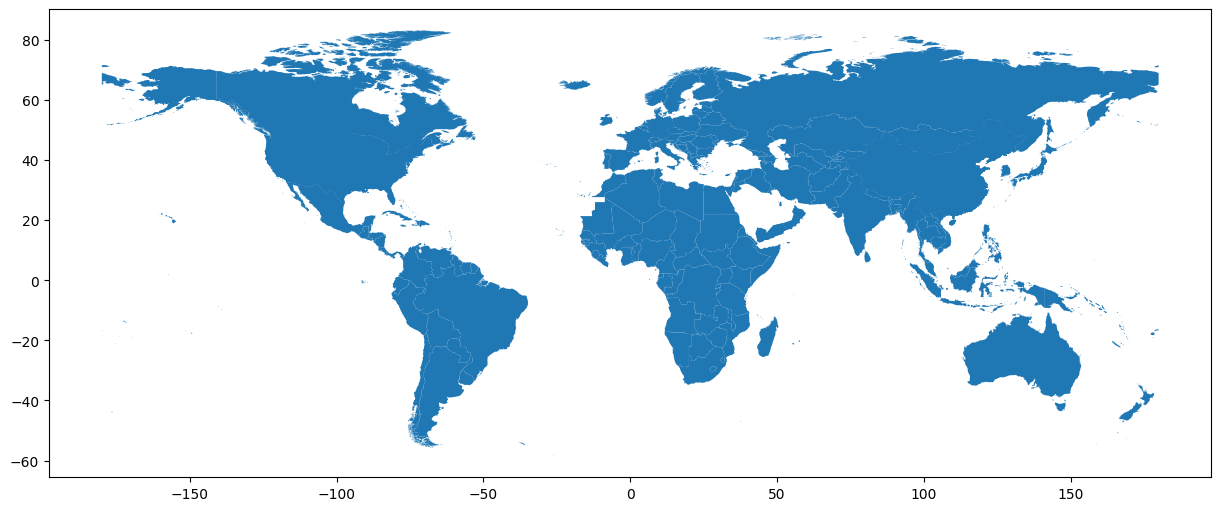

In [152]:
# then
theMapAndData.plot(figsize=(15, 10))


A DDM can serve as an effective way to show the distribution of people. The most critical tasks are:

* Dot Placement: The dots should be randomly distributed within each polygon to avoid misrepresenting the data.

* Dot Unit: Deciding how many people each dot should represent is key for visual clarity. This value should be chosen carefully to avoid oversaturation or sparsity.

The size of all dots on the map must be the same to ensure a consistent visual comparison.

### Preprocessing: aggregating

This is a DOT UNIT proposal:

In [153]:
# This is a DOT UNIT proposal, adapted for the world data

justDots=theMapAndData.copy()
dot_value = 1000
justDots['num_dots'] = (justDots['Value'] / dot_value).astype(int)

### Preprocessing: distributing dots

And here, we get a location for the dots:

In [154]:
# 2. Generate the random dot locations using .sample_points()
justDots = justDots.sample_points(size=justDots['num_dots']).explode(index_parts=True)

You get this:

In [155]:
justDots

1    0       POINT (62.87512 33.30923)
     1       POINT (62.98875 34.47599)
     2       POINT (63.65613 29.65019)
     3       POINT (64.15271 30.86152)
     4       POINT (64.85246 36.77462)
                       ...            
202  672    POINT (140.90603 -8.28235)
     673    POINT (140.92643 -4.32657)
     674    POINT (140.94037 -5.46232)
     675    POINT (140.96309 -8.56049)
     676    POINT (140.96719 -7.57151)
Name: sampled_points, Length: 30836, dtype: geometry

In [157]:
# what is it?
type(justDots)

geopandas.geoseries.GeoSeries

### Preprocessing: building GDF from GS

Notice the multi index (MI), one for a country and for a dot. As we are planing to send these points to R, we avoid MI:

In [158]:
justDots.reset_index(drop=True, inplace=True)
world_dots=gpd.GeoDataFrame(geometry=justDots)
world_dots

,geometry
0,POINT (62.87512 33.30923)
1,POINT (62.98875 34.47599)
2,POINT (63.65613 29.65019)
3,POINT (64.15271 30.86152)
4,POINT (64.85246 36.77462)
...,...
30831,POINT (140.90603 -8.28235)
30832,POINT (140.92643 -4.32657)
30833,POINT (140.94037 -5.46232)
30834,POINT (140.96309 -8.56049)


Now you have a GDF:

In [159]:
world_dots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30836 entries, 0 to 30835
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  30836 non-null  geometry
dtypes: geometry(1)
memory usage: 241.0 KB


Juts plot the polygons as the base, and the points as the layer on top!

<Axes: >

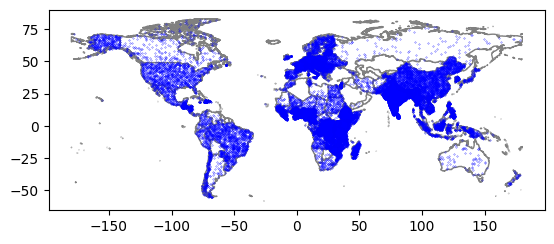

In [160]:
base=theMapAndData.plot(facecolor="white",#color of polygon fill
               edgecolor='grey') #color of border
world_dots.plot(markersize=0.05, color='blue',ax=base)

It is generally recommended that DDMs use an **equal-area projection**, which benefits density and limits area distortion.

<Axes: >

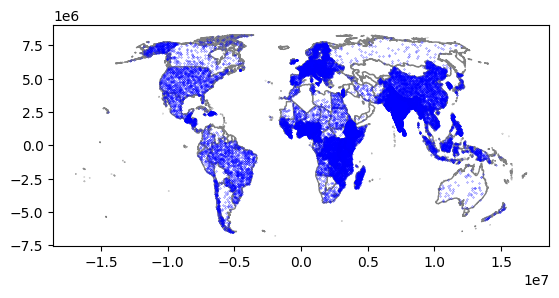

In [161]:
base=world.to_crs(8857).plot(facecolor="white",
                              edgecolor='grey')
world_dots.to_crs(8857).plot(markersize=0.05, color='blue',ax=base)

Let's keep the continent countries with that crs:

In [162]:
theMapAndData_8857 = theMapAndData.to_crs(8857)
world_dots_8857=world_dots.to_crs(8857)

# Thematics: the PSM (Proportional Symbol Map)

You have a PSM if you use a symbol (generally a circle) to show the distribution of a variable per location.
The symbol is an aggregated raw value, and its size varies according to those values. So now we need:

### Preprocessing: GDF of centroids

1. A location for a symbol, generally the polygon centroid.

In [163]:
theMapAndData_8857_centroids = theMapAndData_8857.copy()
_8857 = theMapAndData_8857[theMapAndData_8857['Region'] == 'theMapAndData']
theMapAndData
# theMapAndData_8857_centroids will have a new geometry:
theMapAndData_8857_centroids['geometry'] = theMapAndData_8857_centroids['geometry'].centroid

2. A size of varying values (not constant as in DDMs). Let's use population again.

In [164]:
theMapAndData_8857_centroids['size'] = theMapAndData_8857_centroids['Value'].apply(lambda x: x**0.5/100)

## or
# import numpy as np
# Africa_8857_centroids['size'] = Africa_8857_centroids['population'].apply(lambda x: np.log10(x))

We got the basics, then:

<Axes: >

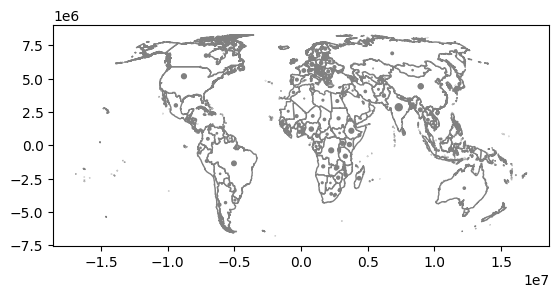

In [165]:
base=theMapAndData_8857.plot(facecolor="white",
                      edgecolor='grey')
# Plot the centroids on top
theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color='grey'
)

In [166]:
!pip install mapclassify

Keep in mind that the standard way of computing centroids may bring some trouble. Let´s plot Seychelles:

In [167]:
base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

A good alternative to centroids is representative_point() when dealing with complex multipolygons.

In [170]:
# replace the points
theMapAndData_8857_centroids["geometry"]=theMapAndData_8857.representative_point()

We will keep that last result.

In [173]:
base=theMapAndData_8857[theMapAndData_8857.Country=="SEYCHELLES"].explore()
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Country=="SEYCHELLES"].explore(m=base,color="red")

### Preprocessing: Computing new columns

PPMs are not thematic maps to see precise values, but to reveal clear differences on the variable distribution used. As, human eyes are very limited to detect area differences, we may need to use some other tactics to help uncover some patterns.

For example, let's confirm if we have outliers:

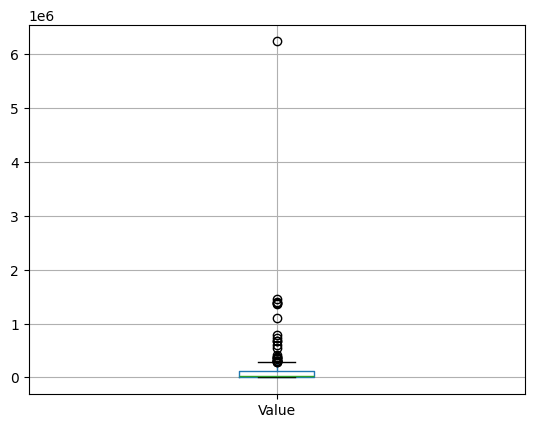

In [174]:
boxplotInfo=theMapAndData_8857_centroids.boxplot(column='Value',return_type="dict")

The object **boxplotInfo** showed the boxplot, and we confirm there are outliers. We can recover them like this:

In [175]:
outliers=boxplotInfo['fliers'][0].get_ydata()
## see
outliers

array([421455, 1108195, 298028, 1357594, 1388157, 1380987, 309242,
       1396178, 375463, 551412, 369926, 6226970, 359500, 723165, 338122,
       296834, 781872, 379482, 294466, 307613, 291342, 598751, 672274,
       1463629, 298618, 677365], dtype=object)

Then, these are the outlying countries:

In [176]:
theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value.isin(outliers)]

,Country,geometry,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,sq_kmGJ,sq_kmTJ,Region,size
20,MYANMAR,POINT (8949132.657 2433783.263),BE,Bioenergy,104,5852,Energy production,6525,Fuelwood,2022,2022,TJ,421455,X,Figure from external organization,0,0.0,Asia,6.491957
25,BRAZIL,POINT (-4700709.502 -1764170.762),BE,Bioenergy,76,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1108195,X,Figure from external organization,8515770000,8515770.0,South America,10.527084
30,CANADA,POINT (-8057335.615 6460418.072),BE,Bioenergy,124,5852,Energy production,6525,Fuelwood,2022,2022,TJ,298028,X,Figure from external organization,9984670000,9984670.0,North America,5.459194
35,DEMOCRATIC REPUBLIC OF THE CONGO,POINT (2150454.367 -516111.79),BE,Bioenergy,180,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1357594,X,Figure from external organization,48670000,48670.0,Africa,11.651584
36,CHINA,POINT (8558589.424 4454406.546),BE,Bioenergy,159,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1388157,X,Figure from external organization,9596960000,9596960.0,Asia,11.782007
37,CHINA,POINT (8558589.424 4454406.546),BE,Bioenergy,156,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1380987,X,Figure from external organization,0,0.0,Unknown,11.751540
40,CAMEROON,POINT (1299556.828 944934.755),BE,Bioenergy,120,5852,Energy production,6525,Fuelwood,2022,2022,TJ,309242,X,Figure from external organization,475440000,475440.0,Africa,5.560953
60,ETHIOPIA,POINT (3713238.555 1171240.545),BE,Bioenergy,231,5852,Energy production,6525,Fuelwood,2022,2022,TJ,1396178,X,Figure from external organization,1104300000,1104300.0,Africa,11.815998
67,FRANCE,POINT (175396.764 5637422.087),BE,Bioenergy,250,5852,Energy production,6525,Fuelwood,2022,2022,TJ,375463,X,Figure from external organization,643801000,643801.0,Europe,6.127504
73,GERMANY,POINT (820014.651 6093052.18),BE,Bioenergy,276,5852,Energy production,6525,Fuelwood,2022,2022,TJ,551412,X,Figure from external organization,357022000,357022.0,Europe,7.425712


Knowing this information, we can create a column as outlier flag:

In [177]:
theMapAndData_8857_centroids['Value_outlier']=theMapAndData_8857_centroids.Value.isin(outliers)*1

## see
theMapAndData_8857_centroids

,Country,geometry,Domain Code,Domain,Area Code (M49),Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,sq_kmGJ,sq_kmTJ,Region,size,Value_outlier
0,ARUBA (NETHERLANDS),POINT (-6627435.863 1600262.217),BE,Bioenergy,533,5852,Energy production,6525,Fuelwood,2022,2022,TJ,24,X,Figure from external organization,0,0.0,Unknown,0.048990,0
1,AFGHANISTAN,POINT (5737749.881 4223784.83),BE,Bioenergy,4,5852,Energy production,6525,Fuelwood,2022,2022,TJ,18558,X,Figure from external organization,652230000,652230.0,Asia,1.362278,0
2,ALGERIA,POINT (58149.408 3504624.452),BE,Bioenergy,12,5852,Energy production,6525,Fuelwood,2022,2022,TJ,741,X,Figure from external organization,2381740000,2381740.0,Africa,0.272213,0
3,AZERBAIJAN,POINT (4052504.835 4936297.741),BE,Bioenergy,31,5852,Energy production,6525,Fuelwood,2022,2022,TJ,643,X,Figure from external organization,86600000,86600.0,Asia,0.253574,0
4,ALBANIA,POINT (1690025.667 5046293.422),BE,Bioenergy,8,5852,Energy production,6525,Fuelwood,2022,2022,TJ,6155,X,Figure from external organization,28748000,28748.0,Europe,0.784538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,ZAMBIA,POINT (2407586.605 -1678163.786),BE,Bioenergy,894,5852,Energy production,6525,Fuelwood,2022,2022,TJ,298618,X,Figure from external organization,752618000,752618.0,Africa,5.464595,1
200,ZIMBABWE,POINT (2738721.618 -2417820.45),BE,Bioenergy,716,5852,Energy production,6525,Fuelwood,2022,2022,TJ,213166,X,Figure from external organization,390757000,390757.0,Africa,4.616990,0
201,SOUTH SUDAN,POINT (2780382.012 1002979.353),BE,Bioenergy,728,5852,Energy production,6525,Fuelwood,2022,2022,TJ,8348,X,Figure from external organization,644329000,644329.0,Africa,0.913674,0
202,INDONESIA,POINT (10855969.809 11510.466),BE,Bioenergy,360,5852,Energy production,6525,Fuelwood,2022,2022,TJ,677365,X,Figure from external organization,1904569000,1904569.0,Asia,8.230219,1


We can use that like this:

<Axes: >

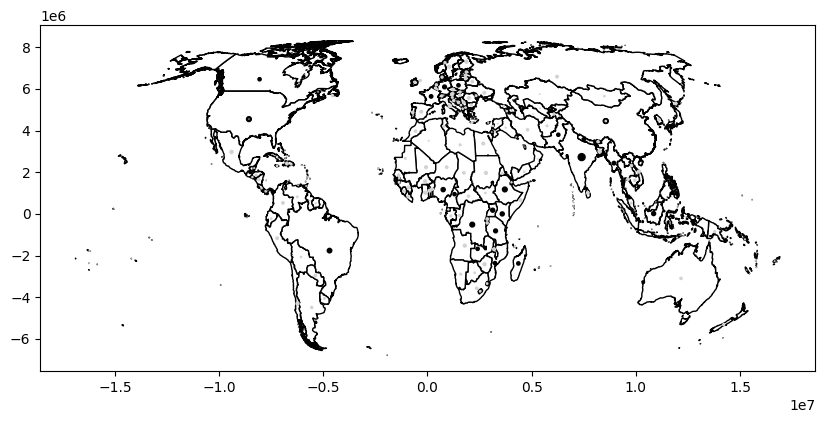

In [94]:
base = theMapAndData_8857.plot(color='white', edgecolor='black', figsize=(10,10))

# Define your color map
mapcolor = {1: 'black', 0: 'lightgrey'}

# Plot the centroids on top
theMapAndData_8857_centroids.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids['size'],
    color=theMapAndData_8857_centroids['Value_outlier'].map(mapcolor)
)

Here, we do a good job for outliers, but it is difficult to interprete the other ones. We could use some redundancy, but more work is needed:
1. Create two maps of centroids:

In [95]:
# Create explicit copies of the DataFrames
theMapAndData_8857_centroids_out = theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value_outlier==1].copy()
theMapAndData_8857_centroids_no_out = theMapAndData_8857_centroids[theMapAndData_8857_centroids.Value_outlier==0].copy()


2. Compute sizes in each:

In [96]:
theMapAndData_8857_centroids_out['size'] = theMapAndData_8857_centroids_out['Value'].apply(lambda x: x**0.5 / 50)
theMapAndData_8857_centroids_no_out['size'] = theMapAndData_8857_centroids_no_out['Value'].apply(lambda x: x**0.5 / 50)

Now, plot the three layers, using some color gradient for the non-outliers:

<Axes: >

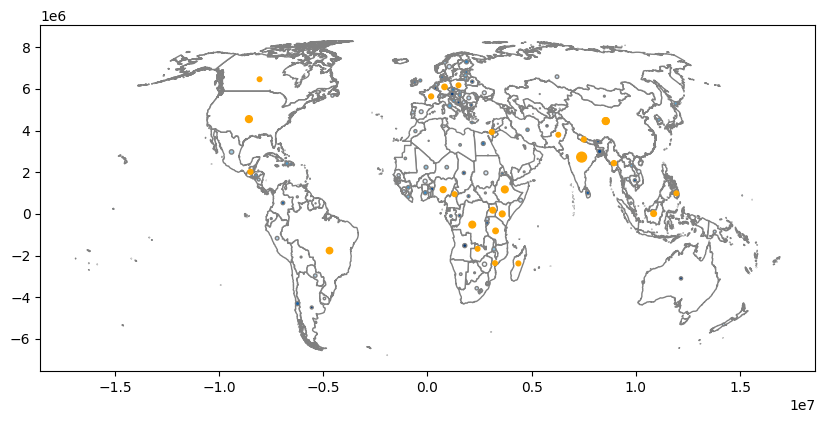

In [97]:
base=theMapAndData_8857.plot(color='white', edgecolor='grey',figsize=(10,10))

theMapAndData_8857_centroids_no_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_no_out['size'],
    edgecolor='grey',
    c=theMapAndData_8857_centroids_no_out['size'],
    cmap='Blues_r'
)
theMapAndData_8857_centroids_out.plot(
    ax=base,
    markersize=theMapAndData_8857_centroids_out['size'],
    color='orange'
)

# Thematics: Choropleths

Notice that the DDMs may use aggregated counts, and the PSMs use the variables in its original form. Choropleths will 'paint' the whole polygon and as noticed in PSMs, we have to be very careful when using color in shape, as the area itself is a confounding. To control this visual artifact, the variable must be normalized, that is, divided by a value correlated with the area.

Then, for this course, a choropleth is a normalized representation of data.

Following our definition:

* This is **NOT** a choropleth:


<Axes: >

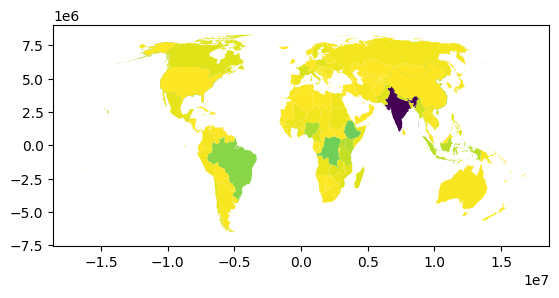

In [185]:
theMapAndData_8857.plot(theMapAndData_8857.Value, cmap='viridis_r')

* This **IS** a choropleth:

<Axes: >

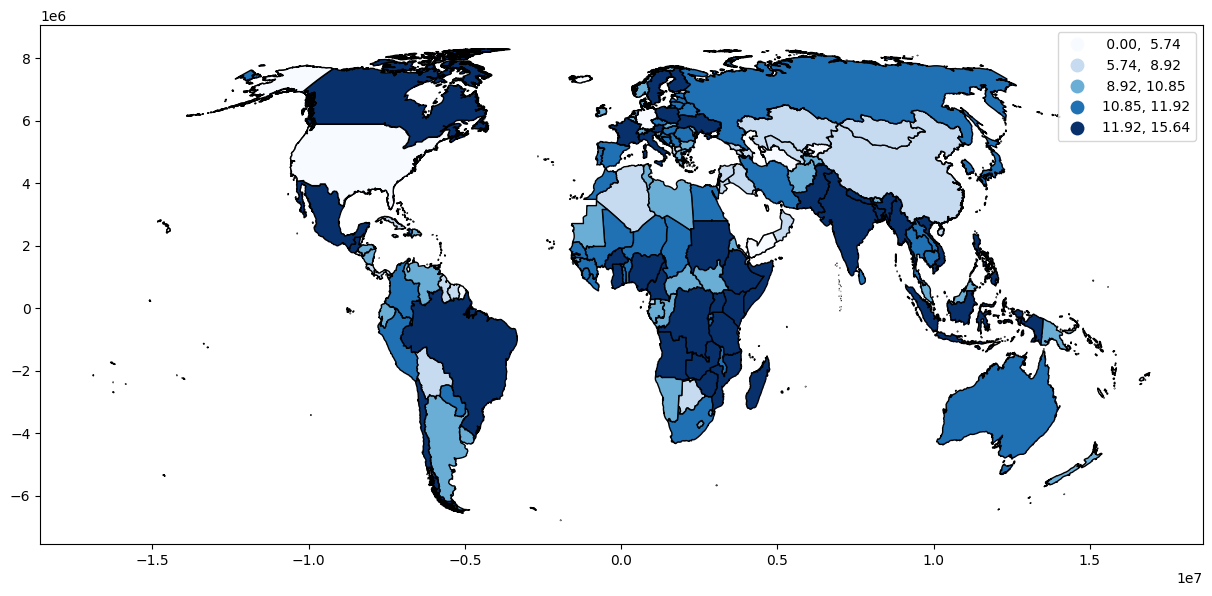

In [187]:
import numpy as np

# Transformación log en columna que existe en el DataFrame con polígonos (no centroides)
theMapAndData_8857['sq_kmGJ'] = np.log1p(theMapAndData_8857['Value'])

# Graficar con polígonos coloreados
theMapAndData_8857.plot(
    column='sq_kmGJ',
    cmap='Blues', # Changed colormap to Blues
    scheme='quantiles',
    k=5,
    legend=True,
    edgecolor='black',
    figsize=(15, 10)
)

Choropleths are great to represent normalized indicators such as:
* Densities
* Ratios
* Rates
* Averages

Population by area is a density indicator. This is a real number (not an integer), so most of the time the color gradient might  not be
that useful to reveal some pattern visually. Then, we often discretize (or bin) the indicator computed.

### Preprocessing: Discretizing

Now, we want to cut the variable. Run the next code to make sure you have tose packages:

In [188]:
## do you have these installed?
! pip show numba mapclassify numpy

Name: numba
Version: 0.60.0
Summary: compiling Python code using LLVM
Home-page: https://numba.pydata.org
Author: 
Author-email: 
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: llvmlite, numpy
Required-by: cudf-cu12, cuml-cu12, dask-cuda, distributed-ucxx-cu12, librosa, numba-cuda, pynndescent, shap, stumpy, umap-learn
---
Name: mapclassify
Version: 2.10.0
Summary: Classification Schemes for Choropleth Maps.
Home-page: 
Author: 
Author-email: 
License: BSD 3-Clause
Location: /usr/local/lib/python3.12/dist-packages
Requires: networkx, numpy, pandas, scikit-learn, scipy
Required-by: 
---
Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:


We will discretize this:

In [189]:
#theMapAndData_8857['Value_density']=theMapAndData_8857.Value/theMapAndData_8857.sq_kmGJ

In [102]:
#theVar = theMapAndData_8857['Value_density'].fillna(0).astype(float)

In [103]:
#theVar = theVar[theVar > 0]

In [192]:
theMapAndData_8857['sq_kmGJ'] = theMapAndData_8857.geometry.area / 1e6
theMapAndData_8857['bioenergia_por_km2'] = theMapAndData_8857['Value'] / theMapAndData_8857['sq_kmGJ']


In [193]:
import mapclassify
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
theVar = theMapAndData_8857['Value']
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(theVar, k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(theVar)
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts
q5=mapclassify.Quantiles(theVar,k=K)

# based on similarity, good for multimodal data
mb5 = mapclassify.MaximumBreaks(theVar, k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(theVar) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(theVar, k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(theVar, k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)

Let's explore the bining algorithms:

How can we select the right classification?
Let me use the the Absolute deviation around class median (ADCM) to make the comparisson:

In [195]:
class5 = ei5,msd, q5,mb5,  ht, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']

Now, plot the **adcms**:

<Axes: ylabel='Classifier'>

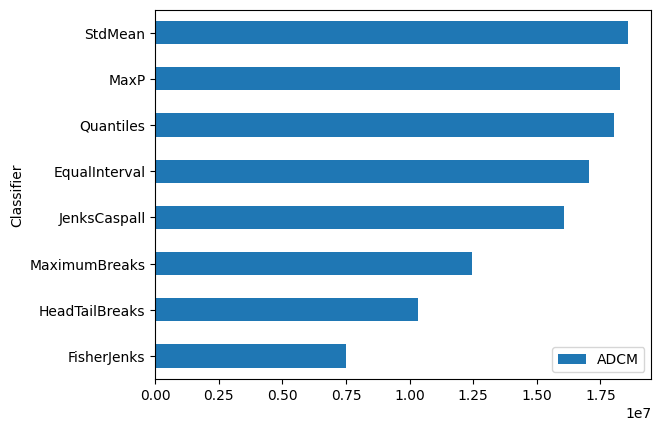

In [196]:
adcms.sort_values('ADCM').plot.barh(x='Classifier')

Let's save the best strategy:

In [198]:
theMapAndData_8857['Value_density_FJ5'] = fj5.yb

In [199]:
# there you are
theMapAndData_8857[['Value_density','Value_density_FJ5']].head(20)

,Value_density,Value_density_FJ5
0,7.456019,0
1,1888.141960,0
2,112.113912,0
3,99.417123,0
4,705.429371,0
5,590.763217,0
6,14696.984233,1
7,4716.190863,0
8,6218.990740,0
9,13781.159757,1


We could create a copy of the bins to add labels:

In [201]:
# renaming
newLabelsForLevels={0:"0_VeryLow", 1:"1_Low", 2:"2_Middle", 3:"3_High", 4:"4_VeryHigh"}

theMapAndData_8857['Value_density_FJ5_cat']=theMapAndData_8857.loc[:,'Value_density_FJ5'].replace(newLabelsForLevels)

# we have
theMapAndData_8857[['Value_density','Value_density_FJ5','Value_density_FJ5_cat']].head(20)

,Value_density,Value_density_FJ5,Value_density_FJ5_cat
0,7.456019,0,0_VeryLow
1,1888.141960,0,0_VeryLow
2,112.113912,0,0_VeryLow
3,99.417123,0,0_VeryLow
4,705.429371,0,0_VeryLow
5,590.763217,0,0_VeryLow
6,14696.984233,1,1_Low
7,4716.190863,0,0_VeryLow
8,6218.990740,0,0_VeryLow
9,13781.159757,1,1_Low


We are ready for a discrete choropleth:

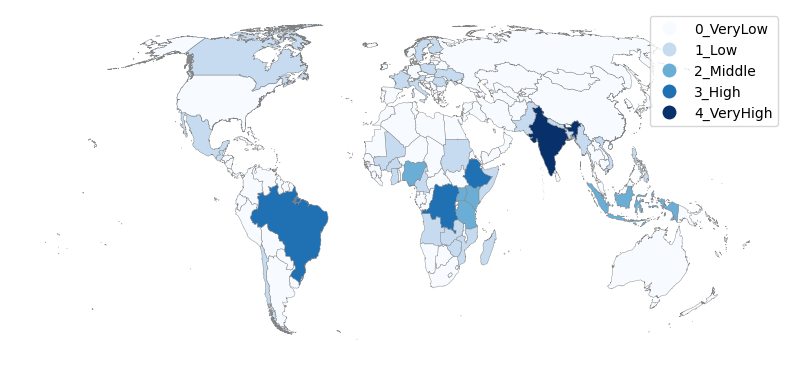

In [205]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(10, 10))
theMapAndData_8857.plot(column='Value_density_FJ5_cat', # variable to plot
                 cmap='Blues', # set of colors
                 categorical=True, # can be interpreted as category
                 edgecolor='grey', # border color
                 linewidth=0.3, # width of border
                 legend=True, # need a legend?
                 ax=ax
       )

ax.set_axis_off()

# Saving

Let's save this maps for R.

In [206]:
## Good practice to refresh your memory

## Find only GeoDataFrames in the current session
geodataframe_list = [var for var in globals() if isinstance(globals()[var], gpd.GeoDataFrame)]

print("List of GeoDataFrames in memory:")
for name in geodataframe_list:
    print(name)

List of GeoDataFrames in memory:
countries
_4
theMapAndData
world
world_dots
_34
theMapAndData_8857
world_dots_8857
theMapAndData_8857_centroids
_8857
_48
_78
_92
_93
theMapAndData_8857_centroids_out
theMapAndData_8857_centroids_no_out
_108
_109
merged
_158
_176
_177


These are the ones needed in R:

In [208]:
# for choropleth and base map
theMapAndData_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Country                204 non-null    object  
 1   geometry               204 non-null    geometry
 2   Domain Code            204 non-null    object  
 3   Domain                 204 non-null    object  
 4   Area Code (M49)        204 non-null    int64   
 5   Element Code           204 non-null    int64   
 6   Element                204 non-null    object  
 7   Item Code              204 non-null    int64   
 8   Item                   204 non-null    object  
 9   Year Code              204 non-null    int64   
 10  Year                   204 non-null    int64   
 11  Unit                   204 non-null    object  
 12  Value                  204 non-null    int64   
 13  Flag                   204 non-null    object  
 14  Flag Description       204 non-nul

In [214]:
# for DDMs
world_dots_8857.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30836 entries, 0 to 30835
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  30836 non-null  geometry
dtypes: geometry(1)
memory usage: 241.0 KB


In [212]:
# for PSMs
theMapAndData_8857_centroids.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           204 non-null    object  
 1   geometry          204 non-null    geometry
 2   Domain Code       204 non-null    object  
 3   Domain            204 non-null    object  
 4   Area Code (M49)   204 non-null    int64   
 5   Element Code      204 non-null    int64   
 6   Element           204 non-null    object  
 7   Item Code         204 non-null    int64   
 8   Item              204 non-null    object  
 9   Year Code         204 non-null    int64   
 10  Year              204 non-null    int64   
 11  Unit              204 non-null    object  
 12  Value             204 non-null    int64   
 13  Flag              204 non-null    object  
 14  Flag Description  204 non-null    object  
 15  sq_kmGJ           204 non-null    int64   
 16  sq_kmTJ           

In [216]:
# for PSMs
theMapAndData_8857_centroids_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 26 entries, 20 to 202
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           26 non-null     object  
 1   geometry          26 non-null     geometry
 2   Domain Code       26 non-null     object  
 3   Domain            26 non-null     object  
 4   Area Code (M49)   26 non-null     int64   
 5   Element Code      26 non-null     int64   
 6   Element           26 non-null     object  
 7   Item Code         26 non-null     int64   
 8   Item              26 non-null     object  
 9   Year Code         26 non-null     int64   
 10  Year              26 non-null     int64   
 11  Unit              26 non-null     object  
 12  Value             26 non-null     int64   
 13  Flag              26 non-null     object  
 14  Flag Description  26 non-null     object  
 15  sq_kmGJ           26 non-null     int64   
 16  sq_kmTJ           26 no

In [218]:
# for PSMs
theMapAndData_8857_centroids_no_out.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 178 entries, 0 to 203
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Country           178 non-null    object  
 1   geometry          178 non-null    geometry
 2   Domain Code       178 non-null    object  
 3   Domain            178 non-null    object  
 4   Area Code (M49)   178 non-null    int64   
 5   Element Code      178 non-null    int64   
 6   Element           178 non-null    object  
 7   Item Code         178 non-null    int64   
 8   Item              178 non-null    object  
 9   Year Code         178 non-null    int64   
 10  Year              178 non-null    int64   
 11  Unit              178 non-null    object  
 12  Value             178 non-null    int64   
 13  Flag              178 non-null    object  
 14  Flag Description  178 non-null    object  
 15  sq_kmGJ           178 non-null    int64   
 16  sq_kmTJ           176 n

The file **africa_8857.gpkg** will keep all those maps as layers!

In [219]:
theMapAndData_8857.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='continent')
theMapAndData_8857.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='Value_ddm')
theMapAndData_8857_centroids.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='Value_psm')
theMapAndData_8857_centroids_out.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='outlier_Value_psm')
theMapAndData_8857_centroids_no_out.to_file("theMapAndData_8857.gpkg",driver='GPKG',layer='no_outlier_Value_psm')